In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
import time

warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

In [3]:
# loading data
X_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_train_balanced.npy"
)
y_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_train_balanced.npy"
)
X_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_test.csv"
)
y_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_test.csv"
)

## Random forest with hyperparamter tuning

In [4]:
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [10, 20, 30, None],  # Tree depth (None = unlimited)
    "min_samples_split": [2, 5, 10],  # Min samples to split node
    "min_samples_leaf": [1, 2, 4],  # Min samples at leaf
    "max_features": ["sqrt", "log2", None],  # Features for best split
    "bootstrap": [True, False],  # Bootstrap samples
}

In [5]:
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    verbose=0,
)

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=50,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

In [7]:
# Train Random Forest with hyperparameter tuning
start_time = time.time()
rf_random.fit(X_train_balanced, y_train_balanced)
search_time = time.time() - start_time
print(search_time)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, max_

In [ ]:
# Best random forest model
rf_best = rf_random.best_estimator_
print(rf_best)


RandomForestClassifier(bootstrap=False, max_depth=20, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)


## Model Evaluation on Test Set

In [12]:
y_pred_rf = rf_best.predict(X_test)
y_pred_proba_rf = rf_best.predict_proba(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average=None, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average=None, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average=None, zero_division=0)

precision_macro_rf = precision_score(
    y_test, y_pred_rf, average="macro", zero_division=0
)
recall_macro_rf = recall_score(y_test, y_pred_rf, average="macro", zero_division=0)
f1_macro_rf = f1_score(y_test, y_pred_rf, average="macro", zero_division=0)

print(f"Overall accuracy : {accuracy_rf}")

Overall accuracy : 0.9948186528497409


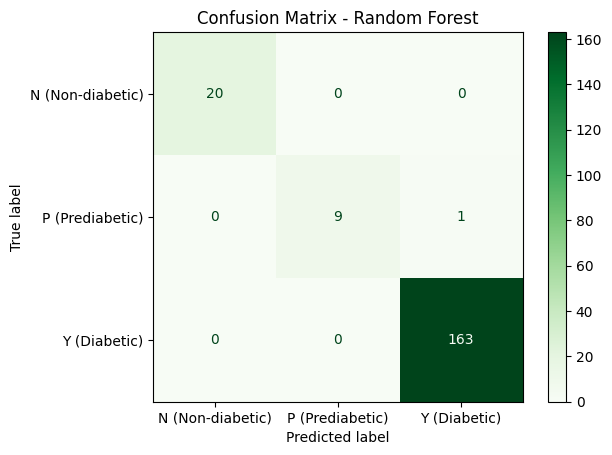

In [16]:
class_names = ["N (Non-diabetic)", "P (Prediabetic)", "Y (Diabetic)"]

cm_rf = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_names)
disp.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

Random Forest provides built-in feature importance based on:
- **Gini Importance**: How much each feature decreases impurity across all trees
- **Higher value** = More important for classification

           Feature  Importance
3            HbA1c    0.485226
9              BMI    0.211609
0              AGE    0.144000
5               TG    0.039946
4             Chol    0.034632
8             VLDL    0.028367
7              LDL    0.017432
1             Urea    0.015125
2               Cr    0.010080
6              HDL    0.009550
10  Gender_encoded    0.004031


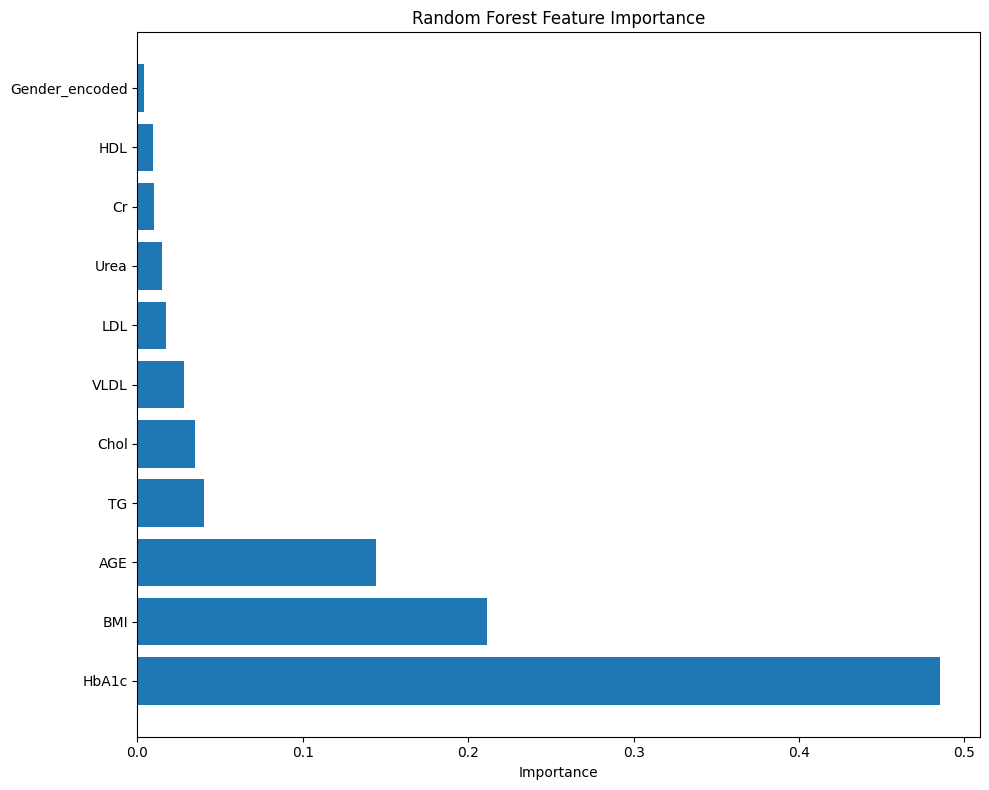

In [14]:
feature_names = X_test.columns.tolist()

importances = rf_best.feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print(importance_df)

plt.figure(figsize=(10, 8))

plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [15]:
# Save model
with open(
    "/home/samir-dahal/Diabetes_Classification/models/classification/random_forest.pkl",
    "wb",
) as f:
    pickle.dump(rf_best, f)

# Save metrics
metrics_df = pd.DataFrame(
    [
        {
            "Model": "Random Forest",
            "Accuracy": accuracy_rf,
            "Precision (macro)": precision_macro_rf,
            "Recall (macro)": recall_macro_rf,
            "F1-Score (macro)": f1_macro_rf,
            "F1 (N)": f1_rf[0],
            "F1 (P)": f1_rf[1],
            "F1 (Y)": f1_rf[2],
            "Training Time (s)": search_time,
            "CV F1 Mean": rf_random.best_score_,
            "CV F1 Std": rf_random.cv_results_["std_test_score"][rf_random.best_index_],
        }
    ]
)

existing_metrics = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/results/classification_results/classification_metrics.csv"
)
updated_metrics = pd.concat([existing_metrics, metrics_df], ignore_index=True)
updated_metrics.to_csv(
    "/home/samir-dahal/Diabetes_Classification/results/classification_results/classification_metrics.csv",
    index=False,
)

print("Model and metrics saved successfully")

Model and metrics saved successfully
